# Генерация графов с помощью графовых нейронных сетей

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

## Традиционные методы

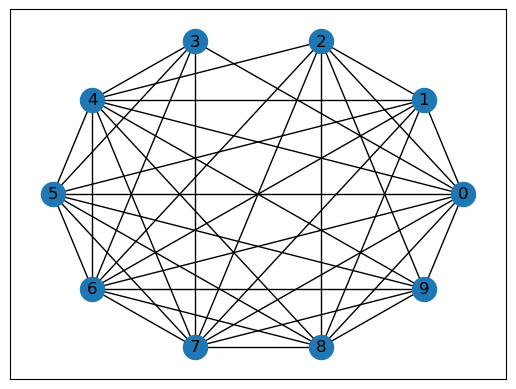

In [2]:
G = nx.erdos_renyi_graph(10, 0.9, seed=0)
pos = nx.circular_layout(G) 
nx.draw_networkx(G, pos=pos)

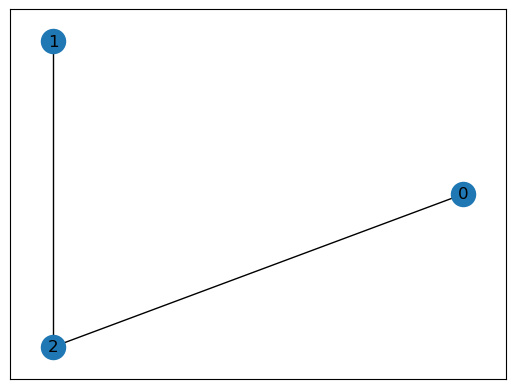

In [3]:
G = nx.gnm_random_graph(3, 2, seed=3)
pos = nx.circular_layout(G) 
nx.draw_networkx(G, pos=pos)

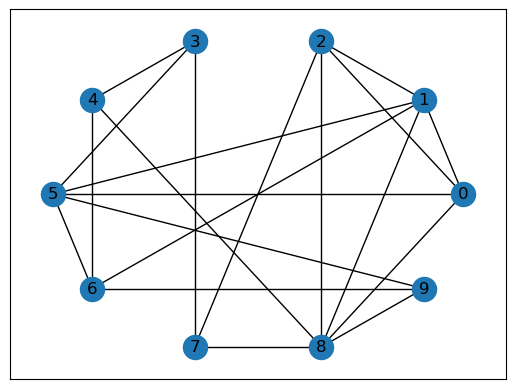

In [4]:
G = nx.watts_strogatz_graph(10, 4, 0.5, seed=0)
pos = nx.circular_layout(G) 
nx.draw_networkx(G, pos=pos)

## Графовые вариационные автоэнкодеры (GVAE)

In [5]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, 
                      num_test=0.1, 
                      is_undirected=True, 
                      split_labels=True, 
                      add_negative_train_samples=False)
])

dataset = Planetoid('.', name='Cora', transform=transform)

train_data, val_data, test_data = dataset[0]

2024-01-28 18:06:47.627848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
from torch_geometric.nn import GCNConv, VGAE

class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, 2 * dim_out)
        self.conv_mu = GCNConv(2 * dim_out, dim_out)
        self.conv_logstd = GCNConv(2 * dim_out, dim_out)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

model = VGAE(Encoder(dataset.num_features, 16)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    loss = model.recon_loss(z, train_data.pos_edge_label_index) + (
        1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, 
                      data.neg_edge_label_index)

for epoch in range(301):
    loss = train()
    val_auc, val_ap = test(val_data)
    if epoch % 50 == 0: 
        print(f'Эпоха {epoch:>3}:\n| AUC-ROC на валид. наборе {val_auc:.4f} | '
              f'AP на валид. наборе: {val_ap:.4f}')

val_auc, val_ap = test(val_data)
print(f'\nAUC-ROC на тестовом наборе: {val_auc:.4f} | ' 
      f'AP на тестовом наборе {val_ap:.4f}')

Эпоха   0:
| AUC-ROC на валид. наборе 0.6920 | AP на валид. наборе: 0.7328
Эпоха  50:
| AUC-ROC на валид. наборе 0.6986 | AP на валид. наборе: 0.7230
Эпоха 100:
| AUC-ROC на валид. наборе 0.7213 | AP на валид. наборе: 0.7455
Эпоха 150:
| AUC-ROC на валид. наборе 0.7708 | AP на валид. наборе: 0.7759
Эпоха 200:
| AUC-ROC на валид. наборе 0.8513 | AP на валид. наборе: 0.8520
Эпоха 250:
| AUC-ROC на валид. наборе 0.8734 | AP на валид. наборе: 0.8715
Эпоха 300:
| AUC-ROC на валид. наборе 0.8697 | AP на валид. наборе: 0.8685

AUC-ROC на тестовом наборе: 0.8697 | AP на тестовом наборе 0.8685


In [7]:
z = model.encode(test_data.x, test_data.edge_index)
adj = torch.where((z @ z.T) > 0.9, 1, 0)
adj

tensor([[0, 0, 0,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 1, 1],
        [1, 0, 1,  ..., 0, 1, 1]])

## MolGAN

In [8]:
import pandas as pd
import numpy as np
from tensorflow import one_hot

import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import IPythonConsole

In [9]:
_, datasets, _ = dc.molnet.load_tox21()
df = pd.DataFrame(datasets[0].ids, columns=['smiles'])
df

,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


In [10]:
# определяем максимальное количество атомов
max_atom = 15

# создаем экземпляр класса MolGanFeaturizer,
# по сути создаем конструктор признаков
featurizer = dc.feat.MolGanFeaturizer(max_atom_count=max_atom)
# отбираем молекулы с количеством атомов меньше максимального
molecules = [x for x in df['smiles'].values 
             if Chem.MolFromSmiles(x).GetNumAtoms() < max_atom]

# создаем список для хранения признаков
features = []

# проход по молекулам и их преобразование в признаки
for x in molecules:
    # создаем объект молекулы из строкового 
    # представления SMILES
    mol = Chem.MolFromSmiles(x)
    # получение канонического порядка атомов
    new_order = rdmolfiles.CanonicalRankAtoms(mol)
    # перенумерация атомов в соответствии 
    # с каноническим порядком
    mol = rdmolops.RenumberAtoms(mol, new_order)
    # извлечение признаков с помощью featurizer
    feature = featurizer.featurize(mol)
    # проверка наличия признаков перед
    # добавлением в словарь
    if feature.size != 0:
        features.append(feature[0])

[18:06:59] WARNING: not removing hydrogen atom without neighbors
Failed to featurize datapoint 0, CC(O)(P(=O)(O)O)P(=O)(O)O. Appending empty array
Exception message: 15
Failed to featurize datapoint 0, CCCCNC(=S)NCCCC. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Ca+2]. Appending empty array
Exception message: 20
Failed to featurize datapoint 0, CC(C)CCCCCOC(=O)CCS. Appending empty array
Exception message: 16
[18:06:59] WARNING: not removing hydrogen atom without neighbors
Failed to featurize datapoint 0, F[B-](F)(F)F.[H+]. Appending empty array
Exception message: 5
Failed to featurize datapoint 0, [I-].[K+]. Appending empty array
Exception message: 19
Failed to featurize datapoint 0, C[Si](C)(C)N[Si](C)(C)C. Appending empty array
Exception message: 14
Failed to featurize datapoint 0, C=CC(=O)OCCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CCC[Si](OC)(OC)OC. Appending empty array
Exce

Exception message: 11
Failed to featurize datapoint 0, BrCCCCCBr. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, CCNC(=S)NCC. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, CC(C)(C)S. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, Cl/C=C/Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Cl/C=C\Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, OCC(Cl)CCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CP(=O)([O-])OCCC[Si](O)(O)O. Appending empty array
Exception message: 15
Failed to featurize datapoint 0, CCOC(=O)C(=O)CCCCCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=[Mo](=O)=O. Appending empty array
Exception message: 42
Failed to featurize datapoint 0, CCOP(=S)(S)OCC. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, O=[Cr]O[Cr]=O. Appending 

Exception message: 16
Failed to featurize datapoint 0, CCCCCCCCCCCCBr. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, O=S(=O)(O)C(F)(F)F. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, CCO[Si](C)(OCC)OCC. Appending empty array
Exception message: 14
Failed to featurize datapoint 0, CCSCCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CCCC[Sn](Cl)(Cl)CCCC. Appending empty array
Exception message: 50
Failed to featurize datapoint 0, CO[Si](OC)(OC)OC. Appending empty array
Exception message: 14
Failed to featurize datapoint 0, [C-]#N.[Cu+]. Appending empty array
Exception message: 29
Failed to featurize datapoint 0, CC(C)(C)C(=O)CCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CCCCC(CC)COP(=O)(O)O. Appending empty array
Exception message: 15
Failed to featurize datapoint 0, CC(S)C(=O)NCC(=O)O. Appending empty array
Exception message: 16
Failed to featurize datapoint

Exception message: 17
Failed to featurize datapoint 0, ClCBr. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=C([O-])C(=O)[O-].[Ca+2]. Appending empty array
Exception message: 20
Failed to featurize datapoint 0, Br[Ca]Br. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, CN(C)C(=O)Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, C#CC(O)(/C=C\Cl)CC. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, BrCCCCCCBr. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, O=P([O-])(O)C(Cl)(Cl)P(=O)([O-])O. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CCOP(OCC)OCC. Appending empty array
Exception message: 15
Failed to featurize datapoint 0, CCCCCCC(C)(C)S. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, O=C(O)CC(C(=O)O)S(=O)(=O)O. Appending empty array
Exception message: 16
Failed to featurize datap

Exception message: 16
Failed to featurize datapoint 0, ClCCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, OCC(Br)CBr. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, C[Si](C)(C)Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=[N+]([O-])C(Cl)(Cl)Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=C([O-])CCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CCCCCSCCCCC. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, CC(S)C(C)S. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, O=[Se]=O. Appending empty array
Exception message: 34
Failed to featurize datapoint 0, ClC/C=C\CCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CCOC(=O)NC(O)C(Cl)(Cl)Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, COC(=O)CS. Appending empty a

Exception message: 15
Failed to featurize datapoint 0, CCCCCCCCSCC. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, O=S(O)CO[Na]. Appending empty array
Exception message: 11
Failed to featurize datapoint 0, COP(C)(=O)OC. Appending empty array
Exception message: 15
Failed to featurize datapoint 0, CNC(=O)O/N=C(\C)C(C)S(C)(=O)=O. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, CN(C)C(=S)[S-].CN(C)C(=S)[S-].[Zn+2]. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, [Ca+2].[Cl-].[Cl-]. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CCCCCCCCCI. Appending empty array
Exception message: 53
Failed to featurize datapoint 0, CCCCCCCCCCCCI. Appending empty array
Exception message: 53
Failed to featurize datapoint 0, CC(C)Br. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, C[SiH](O[Si](C)(C)C)O[Si](C)(C)C. Appending empty array
Exception message: 14
Failed 

Exception message: 53
Failed to featurize datapoint 0, IC(I)I. Appending empty array
Exception message: 53
Failed to featurize datapoint 0, FC(F)OC(F)(F)C(F)Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=S(=O)(Cl)c1ccccc1. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, Nc1ccccc1S(=O)(=O)O. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CNC(=O)Nc1ccc(Cl)c(Cl)c1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CC(=O)Nc1ccc(C)c(Cl)c1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, CCOP(=S)(CC)Sc1ccccc1. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, O=C(O)c1cc(Cl)cc(Cl)c1O. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=[N+]([O-])c1cc([As](=O)(O)O)ccc1O. Appending empty a

Exception message: 16
Failed to featurize datapoint 0, CC(=O)Nc1ccc(S(N)(=O)=O)cc1. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, FC(F)(F)c1ccc(Cl)cc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, COC(=O)Nc1ccc(Cl)c(Cl)c1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Nc1cc(Cl)c(N)c(Cl)c1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Nc1c(Cl)cc([N+](=O)[O-])cc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, C=C(C)C(=O)Nc1ccc(Cl)c(Cl)c1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Oc1cc(Cl)c(Cl)cc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=[N+]([O-])c1ccccc1CCl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=[N+]([O-])c1ccc(CCl)cc1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=C(Cl)c1ccc([N+]

Exception message: 17
Failed to featurize datapoint 0, FC(F)(F)c1cccc(Cl)c1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Cc1ccccc1S(=O)(=O)[O-]. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, NC(=O)Nc1ccc([As](=O)(O)O)cc1. Appending empty array
Exception message: 33
Failed to featurize datapoint 0, O=C(O)c1cc(I)cc(I)c1I. Appending empty array
Exception message: 53
Failed to featurize datapoint 0, O=Cc1cc(O)ccc1Br. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, O=[N+]([O-])c1cc(I)c(O)c(I)c1. Appending empty array
Exception message: 53
Failed to featurize datapoint 0, Clc1ccc(C(Cl)(Cl)Cl)cc1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Cc1cc(Cl)c(C)cc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Clc1ccc(Cl)c(Cl)c1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, [O-]c1cc(Cl)c(Cl)cc1Cl. Appending em

Failed to featurize datapoint 0, Oc1ccc(Cl)cc1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Cc1c(Cl)cccc1[N+](=O)[O-]. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Cc1cc(Cl)ccc1O. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Cc1cc(S(=O)(=O)O)c(N)cc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Cc1ccc(N)c(S(=O)(=O)O)c1. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, Cc1cc(N)c(S(=O)(=O)O)cc1Cl. Appending empty array
Exception message: 16
Failed to featurize datapoint 0, Clc1ccccc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Clc1ccc(Cl)cc1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Oc1ccc(Cl)cc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Brc1ccc(Br)c(Br)c1. Appending empty array
Exception message: 35
Failed to featurize dat

Failed to featurize datapoint 0, O=[N+]([O-])c1cc(Cl)c(Cl)c(Cl)c1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, BrCc1ccc(Br)cc1. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, O=C(O)COc1ccc(Cl)cc1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=C(O)c1cc(Cl)ccc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=C(O)c1c(Cl)cccc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=C(O)c1cccc(Cl)c1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=C(O)c1ccc(Cl)cc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=Cc1c(Cl)cccc1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=Cc1ccc(Cl)c(Cl)c1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=C(Cl)c1ccc(F)c(Cl)c1. Appending empty array
Exception message: 17
Fai

Exception message: 17
Failed to featurize datapoint 0, Brc1cccc(-c2ccccc2)c1. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, Brc1ccccc1-c1ccccc1. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, Oc1ccc(-c2ccccc2)c(Cl)c1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Cc1ccc2c(Br)cc(Br)c(O)c2n1. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, Oc1c(Cl)cc(Cl)c2cccnc12. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Cc1ccc2c(Cl)cc(Cl)c(O)c2n1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Oc1c(Br)cc(Br)c2cccnc12. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, Cc1ccc2ccc(Cl)cc2n1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Oc1ccc(Cl)c2cccnc12. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Oc1c(I)cc(Cl)c2cccnc12. Appending 

Exception message: 16
Failed to featurize datapoint 0, Cc1c(Br)ccs1. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, CCC(C)n1c(=O)[nH]c(C)c(Br)c1=O. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, Cc1c(Cl)c(=O)n(C(C)(C)C)c(=O)[nH]1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, Clc1nnc(Cl)c2ccccc12. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=c1[nH]c(=O)n(Cl)c(=O)n1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=c1n(Cl)c(=O)n(Cl)c(=O)n1Cl. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, OCC1(CO)COC(C(Cl)(Cl)Cl)OC1. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, O=[N+]([O-])C1(Br)COCOC1. Appending empty array
Exception message: 35
Failed to featurize datapoint 0, O=C1C(Cl)=C(Cl)C(=O)c2ccccc12. Appending empty array
Exception message: 17
Failed to featurize datapoint 0, OC1

In [11]:
# удаляем невалидные молекулы
features = [x for x in features if type(x) is GraphMatrix]

In [12]:
# создаем MolGAN
gan = MolGAN(
    learning_rate=ExponentialDecay(0.001, 0.9, 5000), 
    vertices=max_atom
)

# создаем набор данных
dataset = dc.data.NumpyDataset(
    X=[x.adjacency_matrix for x in features], 
    y=[x.node_features for x in features]
)
dataset

<NumpyDataset X.shape: (2107, 15, 15), y.shape: (2107, 15), w.shape: (2107, 1), task_names: [ 0  1  2 ... 12 13 14]>

In [13]:
def iterbatches(epochs):
    # итерируем по эпохам
    for i in range(epochs):
        # итерируем по батчам в наборе данных
        for batch in dataset.iterbatches(batch_size=gan.batch_size, 
                                         pad_batches=True):
            # преобразовываем матрицы смежности 
            # и узлы в one-hot тензоры
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            # возвращаем словарь с данными для MolGAN
            yield {gan.data_inputs[0]: adjacency_tensor, 
                   gan.data_inputs[1]: node_tensor}

In [14]:
# обучаем модель
gan.fit_gan(iterbatches(25), 
            generator_steps=0.2, 
            checkpoint_interval=5000)

Ending global_step 549: generator average loss -5.86078, discriminator average loss -19.0696
TIMING: model fitting took 37.146 s


In [15]:
# генерируем 1000 молекул
generated_data = gan.predict_gan_generator(1000)
generated_mols = featurizer.defeaturize(generated_data)

Generating 1000 samples


[18:07:41] Explicit valence for atom # 0 O, 26, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 25, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 25, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 28, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 26, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 28, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 28, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom #

[18:07:41] Explicit valence for atom # 0 O, 26, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 26, is greater than permitted
[18:07:41] Explicit valence for atom # 0 C, 22, is greater than permitted
[18:07:41] Explicit valence for atom # 0 C, 25, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 28, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 26, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 28, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 26, is greater than permitted
[18:07:41] Explicit valence for atom # 0 O, 27, is greater than permitted
[18:07:41] Explicit valence for atom #

In [16]:
# проверяем валидность молекулы (стабильность не гарантирована, 
# поэтому может оказаться, что количество допустимых 
# молекул равно 0
valid_mols = [x for x in generated_mols if x is not None]
print (f"{len(valid_mols)} валидных молекул "
       f"(из {len((generated_mols))} сгенерирированных молекул)")

807 валидных молекул (из 1000 сгенерирированных молекул)


In [17]:
# преобразовываем сгененированные молекулы 
# в строковое представление SMILES
generated_smiles = [Chem.MolToSmiles(x) 
                    for x in valid_mols]
# преобразовываем уникальные строковые представления
# SMILES в молекулы для визуализации
generated_smiles_viz = [Chem.MolFromSmiles(x) 
                        for x in set(generated_smiles)]
# печатаем информацию о количестве 
# уникальных и избыточных молекул
print(f"{len(generated_smiles_viz)} уникальных валидных молекул "
      f"({len(generated_smiles)-len(generated_smiles_viz)} избыточных молекул)")

11 уникальных валидных молекул (796 избыточных молекул)


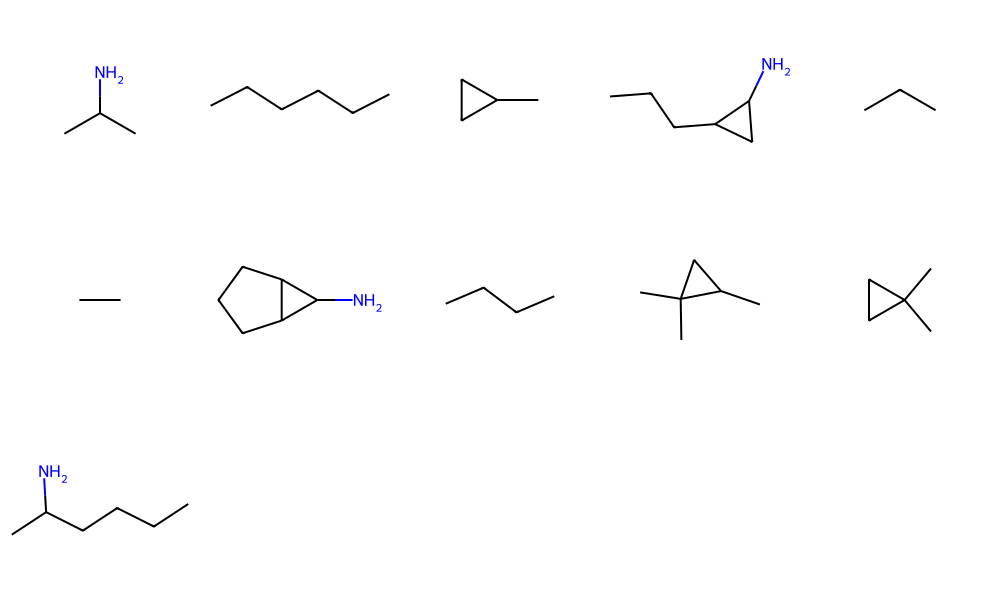

In [18]:
# визуализируем сгенерированные молекулы
# в виде сетки изображений
Draw.MolsToGridImage(generated_smiles_viz, 
                     molsPerRow=5, 
                     subImgSize=(200, 200), 
                     returnPNG=False)